In [54]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
from labellines import labelLine, labelLines
from matplotlib.pyplot import cm
from importlib import reload

import src.utils as utils

In [55]:
reload(utils)

<module 'src.utils' from '/Users/leonardobaggiani/Desktop/amm-fees/src/utils.py'>

In [56]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex = True)
plt.rc("text.latex", preamble=r'\usepackage{amsmath,amsfonts}')
fs = 16
dpi = 300

In [57]:
depth = 100*1000*1000.
y_0 = 1000

In [58]:
y_grid = np.array([i for i in range(980,1021)])

import pickle

params = { "int_sell": 10., "int_buy": 10., "kappa": 1./np.mean(np.diff(y_grid)), "oracleprice": 100., "depth": depth, "y_grid": y_grid, "y_0": y_0, "T": 1., "pen_const": 0.,}

with open("src/params.pkl", "wb") as f:pickle.dump(params,f)

In [59]:
import pickle

with open('src/params.pkl', 'rb') as f:
    params = pickle.load(f)

In [60]:
AMM = utils.AMM(**params)

In [61]:
alpha,beta = AMM._calculate_fees_t(0.5)

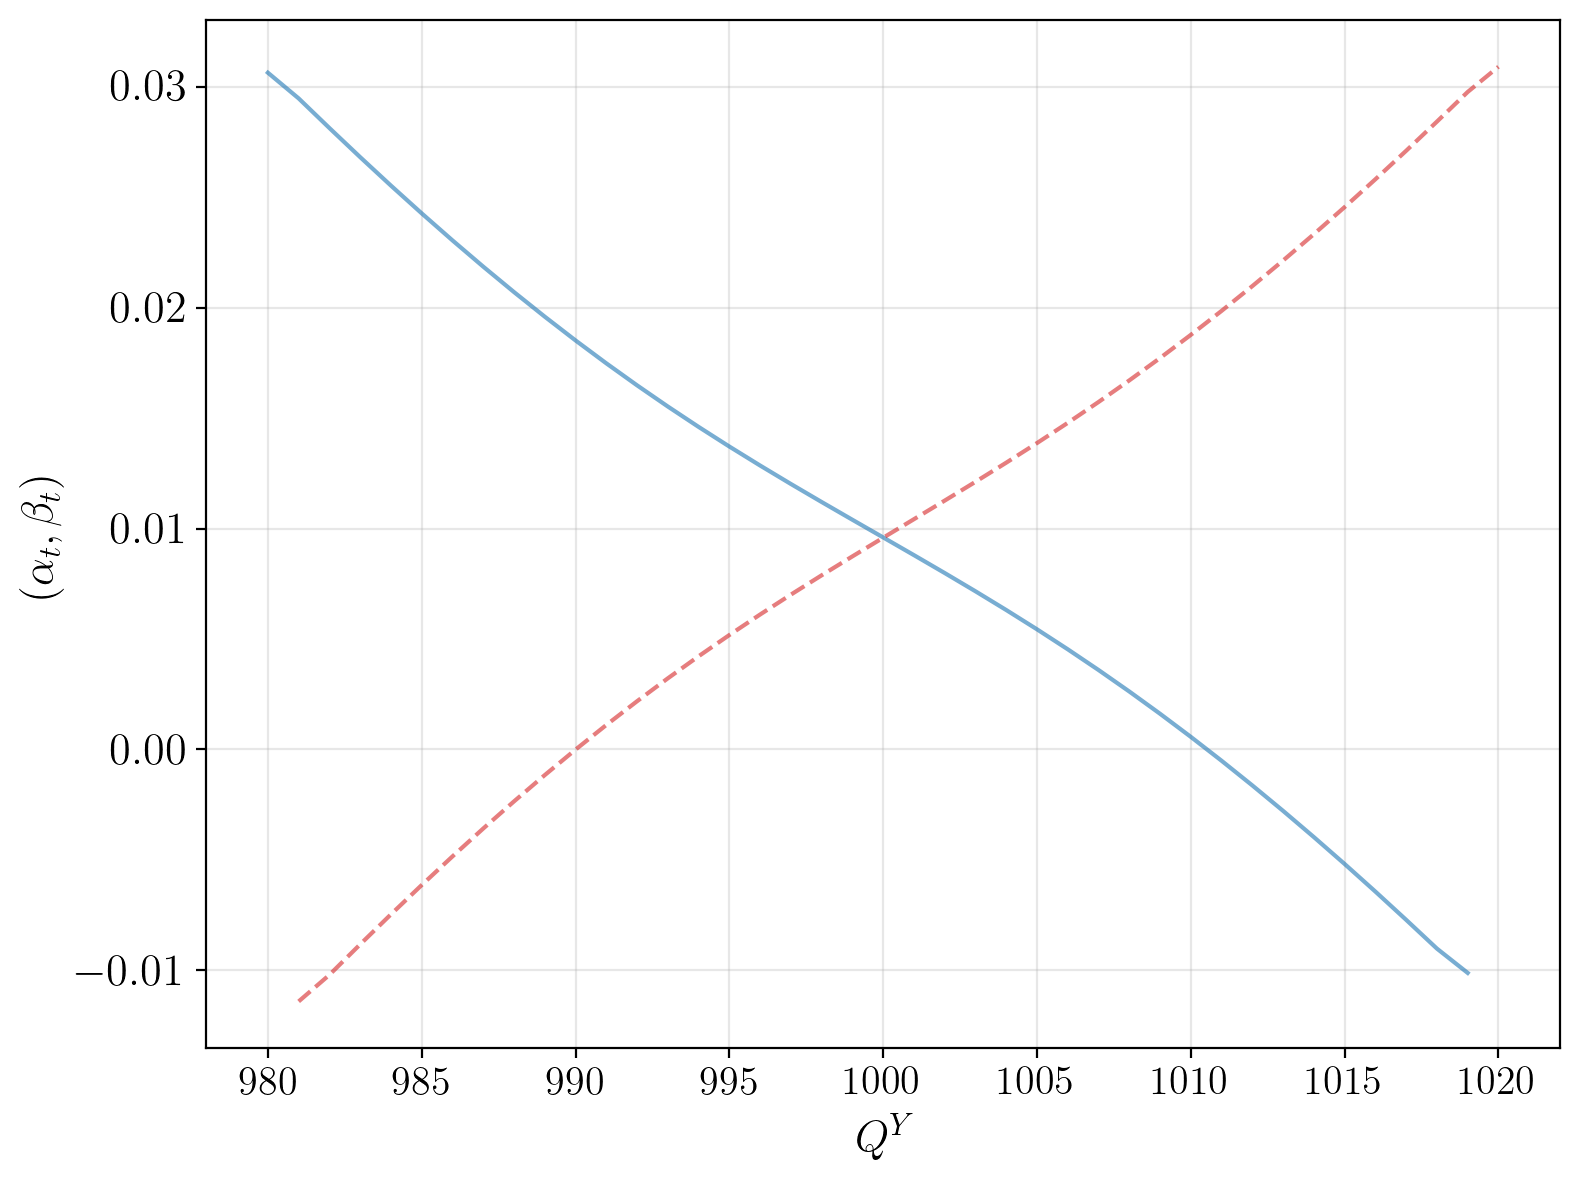

In [62]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, alpha[:], '-', color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, beta[:], '--', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Grid Equispaced in y/Optimal_Fees.pdf', format="pdf", dpi=dpi)
plt.show()

In [63]:
lin_alpha, lin_beta = AMM.get_linear_fees(0.5)

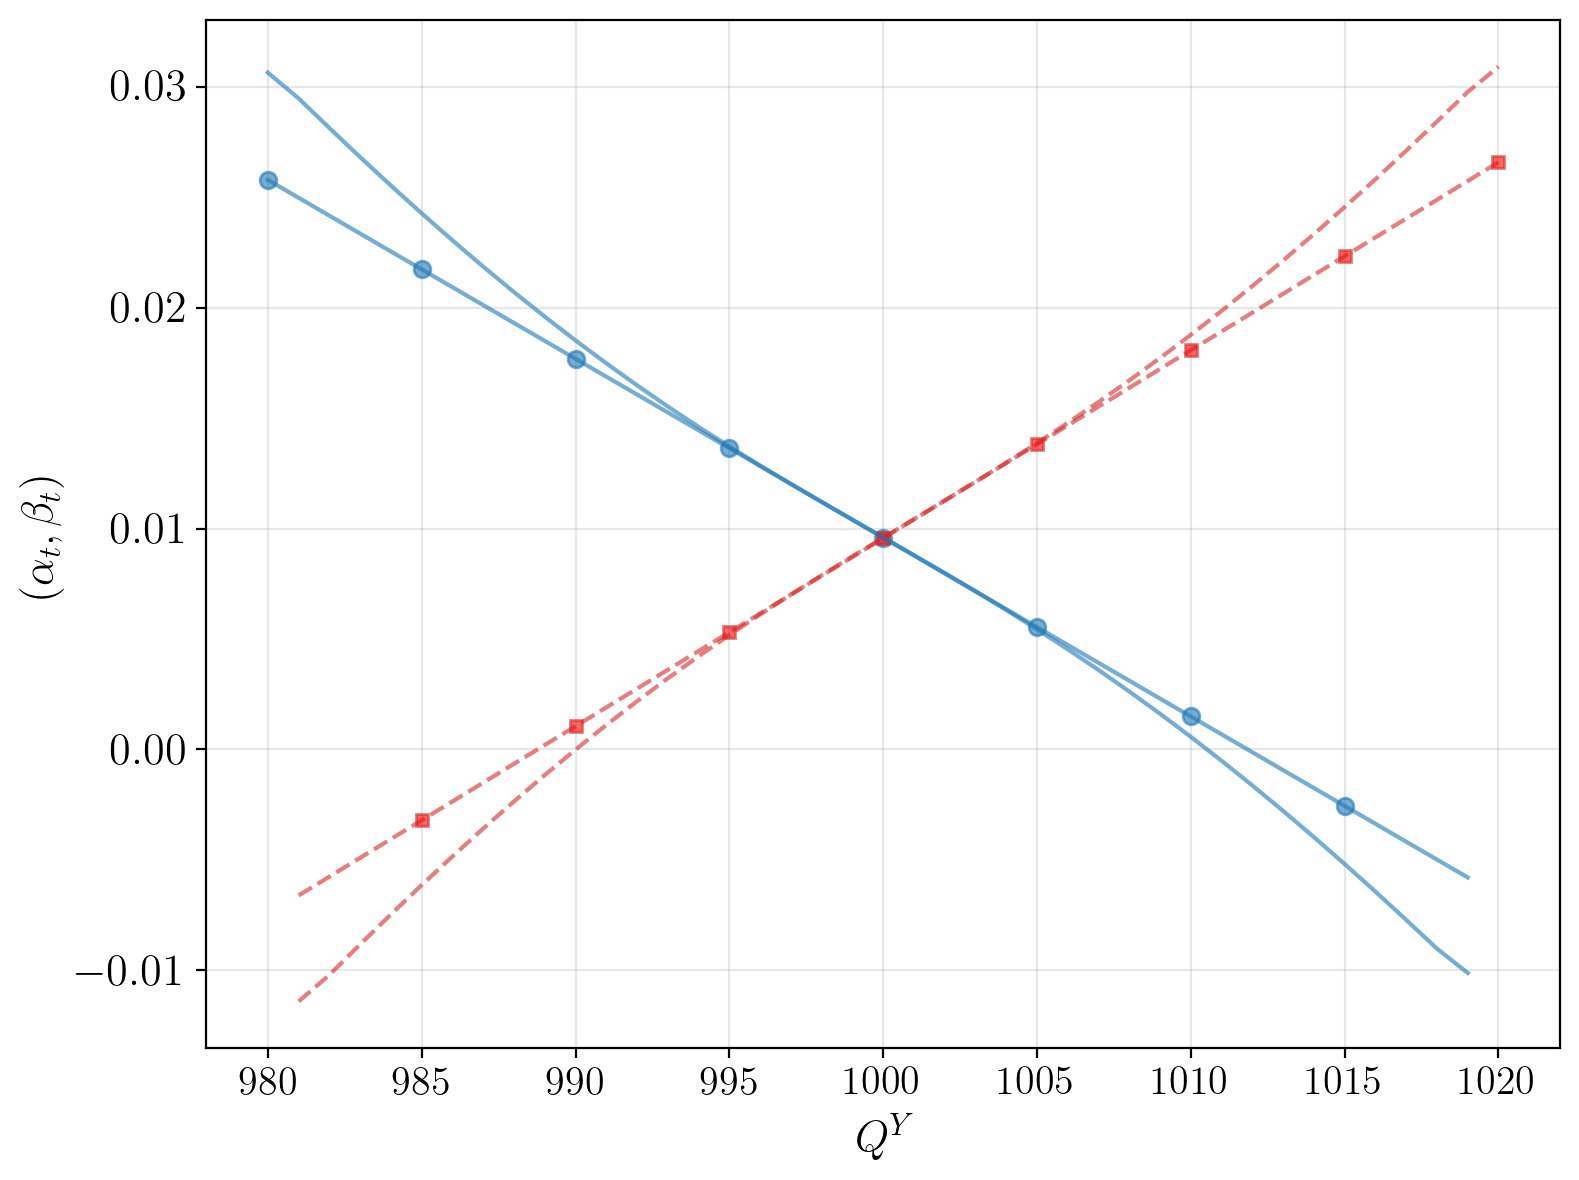

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, lin_alpha[:], '-o', color='tab:blue', alpha=0.6, markevery=5)
ax.plot(AMM.y_grid, lin_beta[:], '--s', color='tab:red', alpha=0.6, markersize=4, markerfacecolor='red', markevery=5)
ax.plot(AMM.y_grid, alpha[:], '-', color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, beta[:], '--', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Grid Equispaced in y/Linear_Fees.pdf', format="pdf", dpi=dpi)
plt.show()

In [65]:
pen_const_value = np.zeros(6)
for i in range(0,5):
    pen_const_value[i+1] = 10**i

In [66]:
alpha = np.ones((len(AMM.y_grid), len(pen_const_value)))
beta = np.ones_like(alpha)
for i, pen_const in enumerate(pen_const_value):
    params_aux = params.copy()
    params_aux["pen_const"] = pen_const
    AMM_aux = utils.AMM(**params_aux)
    alpha[:,i], beta[:,i] = AMM_aux._calculate_fees_t(0.5)

In [67]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin = min(pen_const_value), vmax = max(pen_const_value))
sm = ScalarMappable(norm = norm, cmap=cmap)

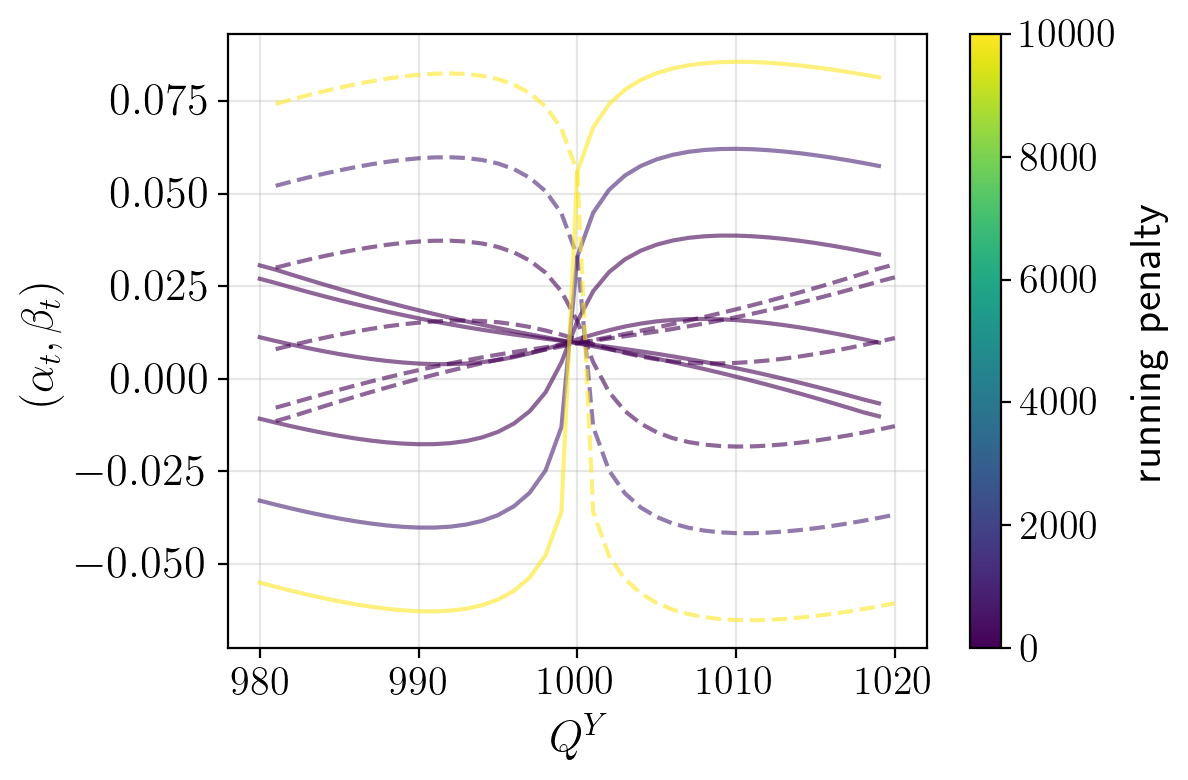

In [68]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

for i,p in enumerate(pen_const_value):
    color = cmap(norm(pen_const_value[i]))
    ax.plot(AMM.y_grid, alpha[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.y_grid, beta[:,i], '--', color=color, alpha=0.6)


plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

cbar = fig.colorbar(sm, ax = ax, orientation = "vertical")
cbar.set_label("running penalty", fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Grid Equispaced in y/Optimal_Fees_Nonzero_penalty.pdf', format="pdf", dpi=dpi)
plt.show()

In [69]:
Nt = 100
t_vector = np.linspace(0, AMM.T,num=Nt)

alpha = np.ones((len(AMM.y_grid), len(t_vector)))
beta = np.ones_like(alpha)

for i,t in enumerate(t_vector):
    alpha[:,i],beta[:,i] = AMM._calculate_fees_t(t)

In [70]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(AMM.y_grid), vmax=max(AMM.y_grid))
sm = ScalarMappable(norm=norm, cmap=cmap)

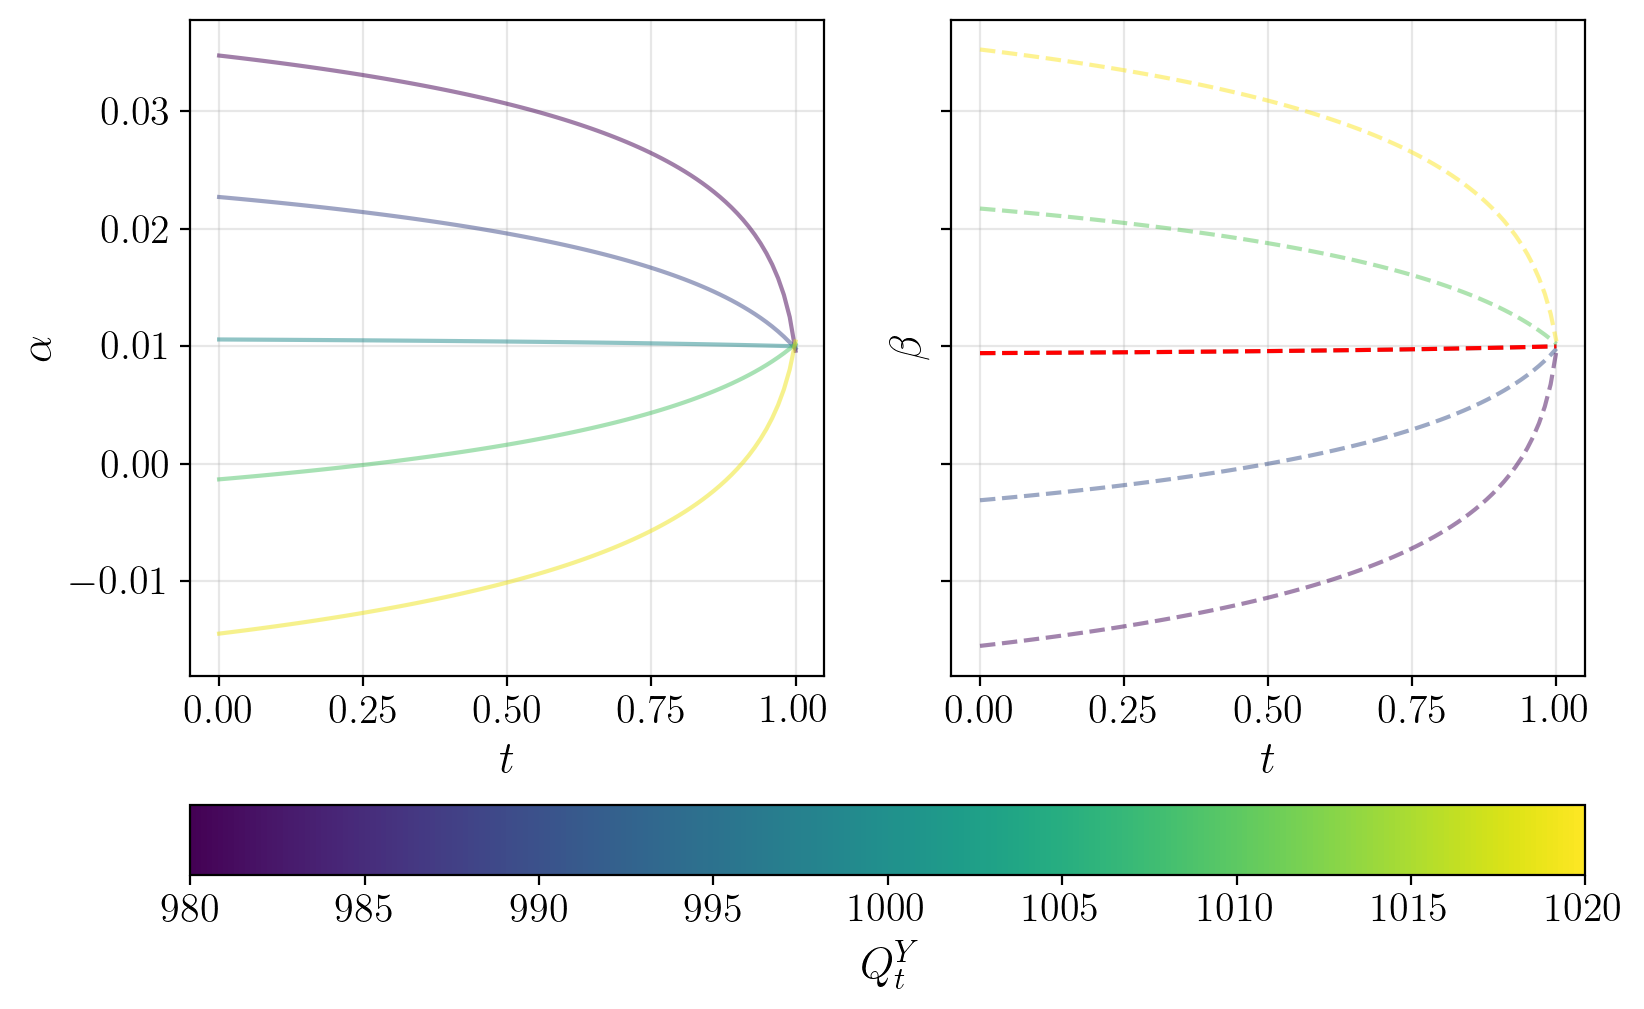

In [71]:
fig, ax = plt.subplots(1,2, figsize = (9,6), sharey=True)
indices_alpha = np.linspace(0, len(alpha)- 2, 5, dtype=int)
indices_beta = np.linspace(1, len(alpha)- 1, 5, dtype=int)
desired_values_alpha = [y_grid[i] for i in indices_alpha]
desired_values_beta = [y_grid[i] for i in indices_beta]
for i,q in enumerate(AMM.y_grid):
    if q in desired_values_alpha:
        color = cmap(norm(AMM.y_grid[i]))
        if q < desired_values_beta[-1]:
            ax[0].plot(t_vector, alpha[i,:],'-', color = color, alpha = 0.5)#, label="q="+str(q), colors[iq])
        if q == AMM.y_0:
            ax[0].plot(t_vector, alpha[i,:],'-', color = "red")#, label="q="+str(q), colors[iq])
    
for i,q in enumerate(AMM.y_grid):
    if q in desired_values_beta:
        color = cmap(norm(AMM.y_grid[i]))
        if q > desired_values_alpha[0]:
            ax[1].plot(t_vector, beta[i,:],'--', color = color, alpha = 0.5) #, label="q="+str(q), colors[iq])
        if q == AMM.y_0:
            ax[1].plot(t_vector, beta[i,:],'--', color = "red") # label=" ", colors[iq])
        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\alpha$', fontsize = fs)
ax[1].set_ylabel(r'$\beta$', fontsize = fs)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.14)
cbar.set_label(r'$Q^Y_t$', fontsize=fs)

#plt.tight_layout()
plt.savefig('figures/Grid Equispaced in y/Optima_fees_through_time_fct_of_Q_t.pdf', format="pdf", dpi=dpi)
plt.show()

In [72]:
(cash_Opt, quantity_Opt, n_sell_order_Opt, n_buy_order_Opt, min_inventory_Opt, max_inventory_Opt)= AMM.simulate_PnL(nsims = 100000, Nt =1_000, c =0.01, strategy = "Optimal")
(cash_Lin, quantity_Lin, n_sell_order_Lin, n_buy_order_Lin, min_inventory_Lin, max_inventory_Lin)= AMM.simulate_PnL(nsims = 100000, Nt =1_000, c =0.01, strategy = "Linear")
(cash_Const, quantity_Const, n_sell_order_Const, n_buy_order_Const, min_inventory_Const, max_inventory_Const)= AMM.simulate_PnL(nsims = 100000, Nt =1_000, c =0.01, strategy = "Constant")

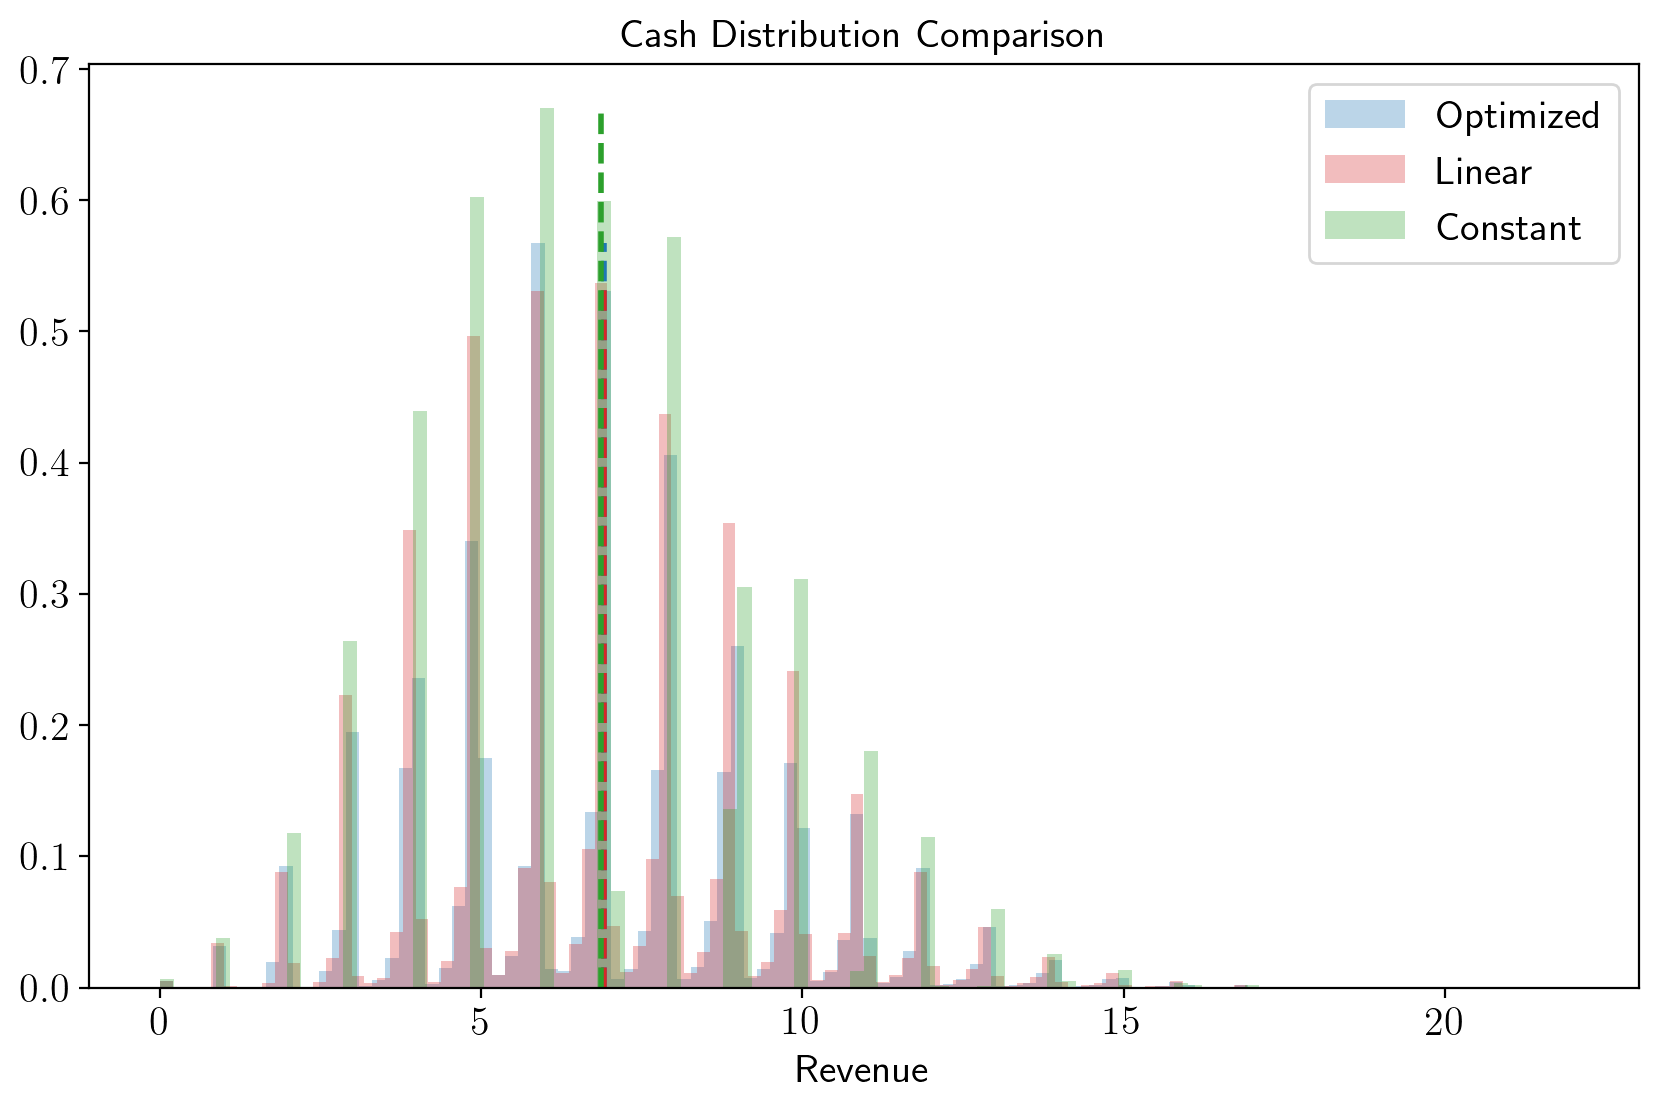

In [73]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and labels
datasets = {
    "Optimized": ("tab:blue", cash_Opt),
    "Linear": ("tab:red", cash_Lin),
    "Constant": ("tab:green", cash_Const),
}

# Plot histograms and mean lines
for label, (color, data) in datasets.items():
    counts, bins, _ = ax.hist(data, bins=100, alpha=0.3, color=color, density=True, label=label)
    ax.vlines(np.mean(data), ymin=0, ymax=max(counts), color=color, linestyle="--", linewidth=2)

# Labels and title
ax.set_xlabel("Revenue")
ax.set_title("Cash Distribution Comparison")
ax.legend()


# Zoom
#plt.xlim([5,10])
plt.savefig('figures/Grid Equispaced in y/Histogram_Revenue.pdf', format="pdf", dpi=dpi)

# Show plot
plt.show()

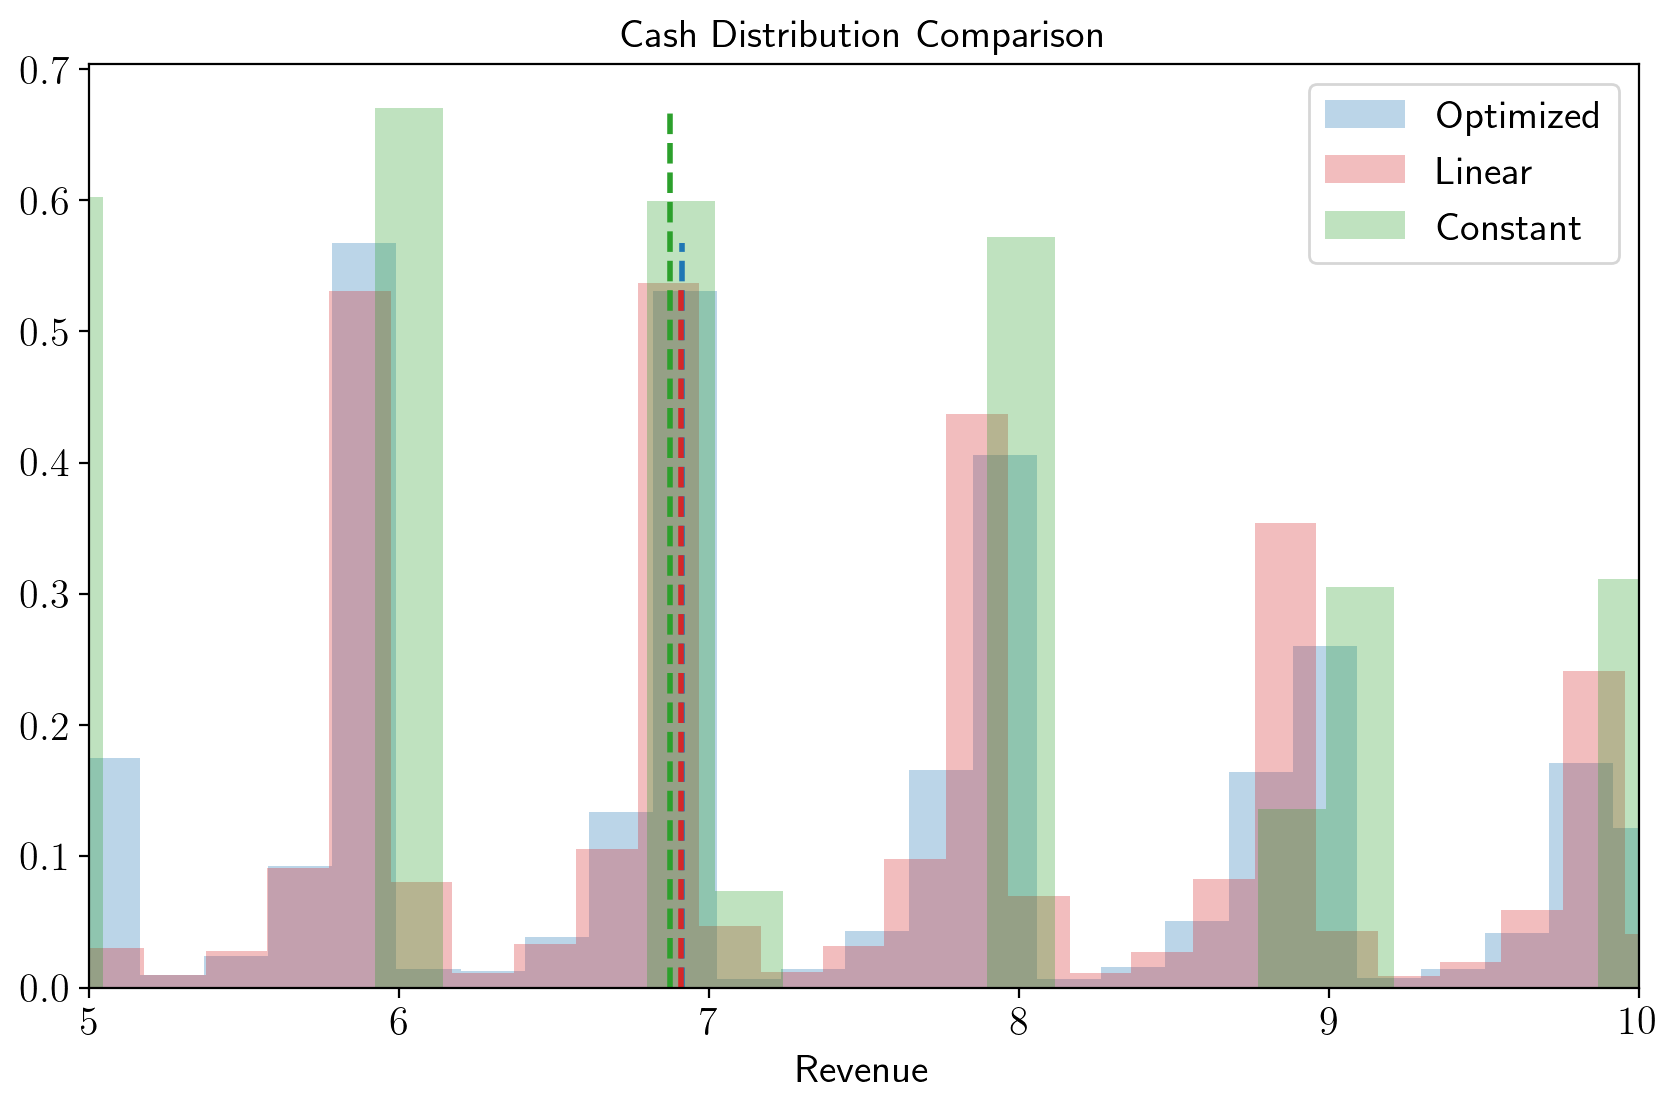

In [74]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and labels
datasets = {
    "Optimized": ("tab:blue", cash_Opt),
    "Linear": ("tab:red", cash_Lin),
    "Constant": ("tab:green", cash_Const),
}

# Plot histograms and mean lines
for label, (color, data) in datasets.items():
    counts, bins, _ = ax.hist(data, bins=100, alpha=0.3, color=color, density=True, label=label)
    ax.vlines(np.mean(data), ymin=0, ymax=max(counts), color=color, linestyle="--", linewidth=2)

# Labels and title
ax.set_xlabel("Revenue")
ax.set_title("Cash Distribution Comparison")
ax.legend()


# Zoom
plt.xlim([5,10])
plt.savefig('figures/Grid Equispaced in y/Histogram_Revenue_zoomed.pdf', format="pdf", dpi=dpi)

# Show plot
plt.show()

In [75]:
Fees = ["Optimal", "Linear", "Constant 0.1"]
Revenue = [np.mean(cash_Opt),np.mean(cash_Lin),np.mean(cash_Const)]
N_sell_order = [np.mean(n_sell_order_Opt),np.mean(n_sell_order_Lin),np.mean(n_sell_order_Const)]
N_buy_order = [np.mean(n_buy_order_Opt),np.mean(n_buy_order_Lin),np.mean(n_buy_order_Const)]
Final_Inventory = [np.mean(quantity_Opt),np.mean(quantity_Lin),np.mean(quantity_Const)]
Min_inventory = [np.mean(min_inventory_Opt),np.mean(min_inventory_Lin),np.mean(min_inventory_Const)]
Max_inventory = [np.mean(max_inventory_Opt),np.mean(max_inventory_Opt),np.mean(max_inventory_Opt)]

In [76]:
df = pd.DataFrame({
    "Fees": Fees,
    "Revenue": Revenue,
    "N Sell Order": N_sell_order,
    "N Buy Order": N_buy_order,
    "Final Inventory": Final_Inventory,
    "Min Inventory": Min_inventory,
    "Max Inventory": Max_inventory,
})

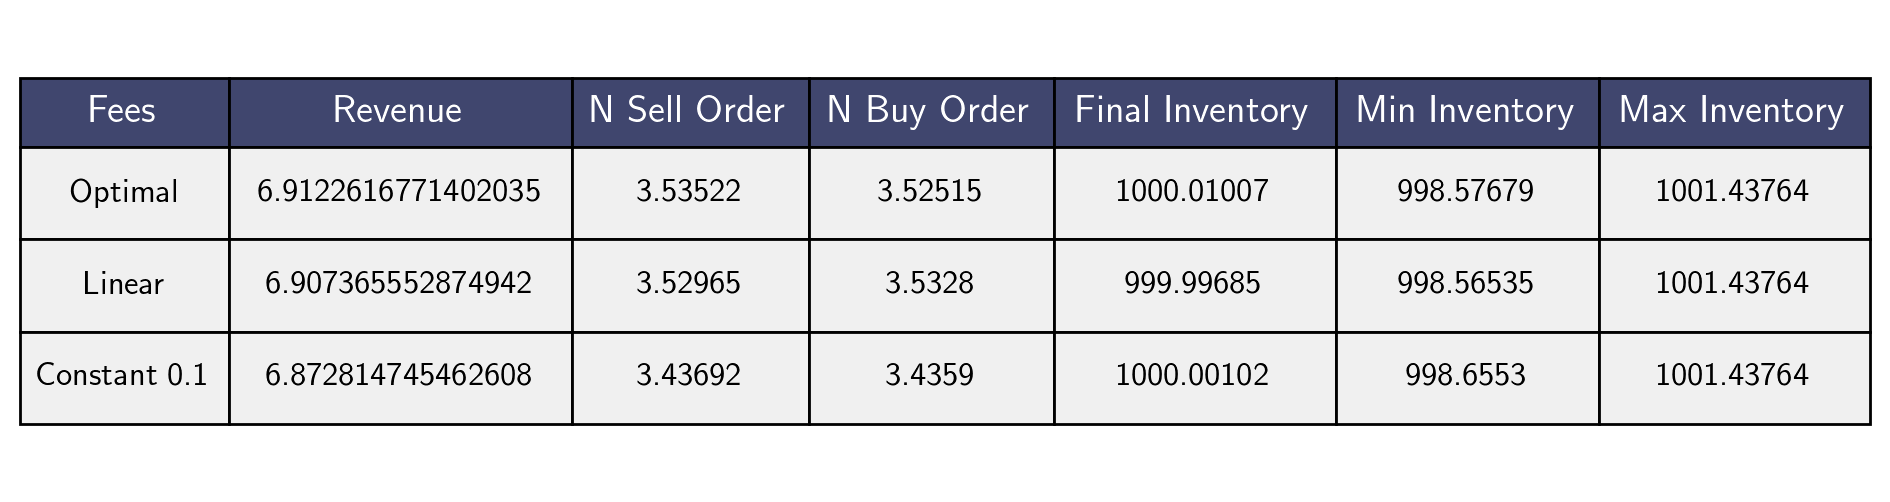

In [77]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))  # Keep image compact
ax.axis('off')  # Hide axis

# Define table colors
header_color = '#40466e'  # Dark blue for header
text_color = 'white'  # White text for header
row_color = '#F0F0F0'  # Light gray for rows

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=[header_color] * len(df.columns)  # Header color
)

# Style table
table.auto_set_font_size(False)
table.set_fontsize(12)  # Bigger text
table.auto_set_column_width(col=list(range(len(df.columns))))  # Auto column width

# Add more padding between rows (increase row height)
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(weight='bold', color=text_color)
        cell.set_fontsize(14)  # Bigger header text
        cell.set_height(0.15)  # Make header taller
    else:  # Data rows
        cell.set_facecolor(row_color)  # Alternating row color
        cell.set_fontsize(12)  # Bigger text
        cell.set_height(0.2)  # More row height for spacing

    cell.set_edgecolor('black')  # Normal border thickness

plt.savefig('figures/Grid Equispaced in y/Table_values_simulation.pdf', format="pdf", dpi=dpi)

In [78]:
y_grid = np.array([np.sqrt((depth) / (depth / ((y_0) ** 2) - i * 0.1)) for i in range(-20, 21)])
params_new_grid = params.copy()
params_new_grid["y_grid"] = y_grid

In [79]:
AMM = utils.AMM(**params_new_grid)

In [80]:
alpha,beta = AMM._calculate_fees_t(0.5)

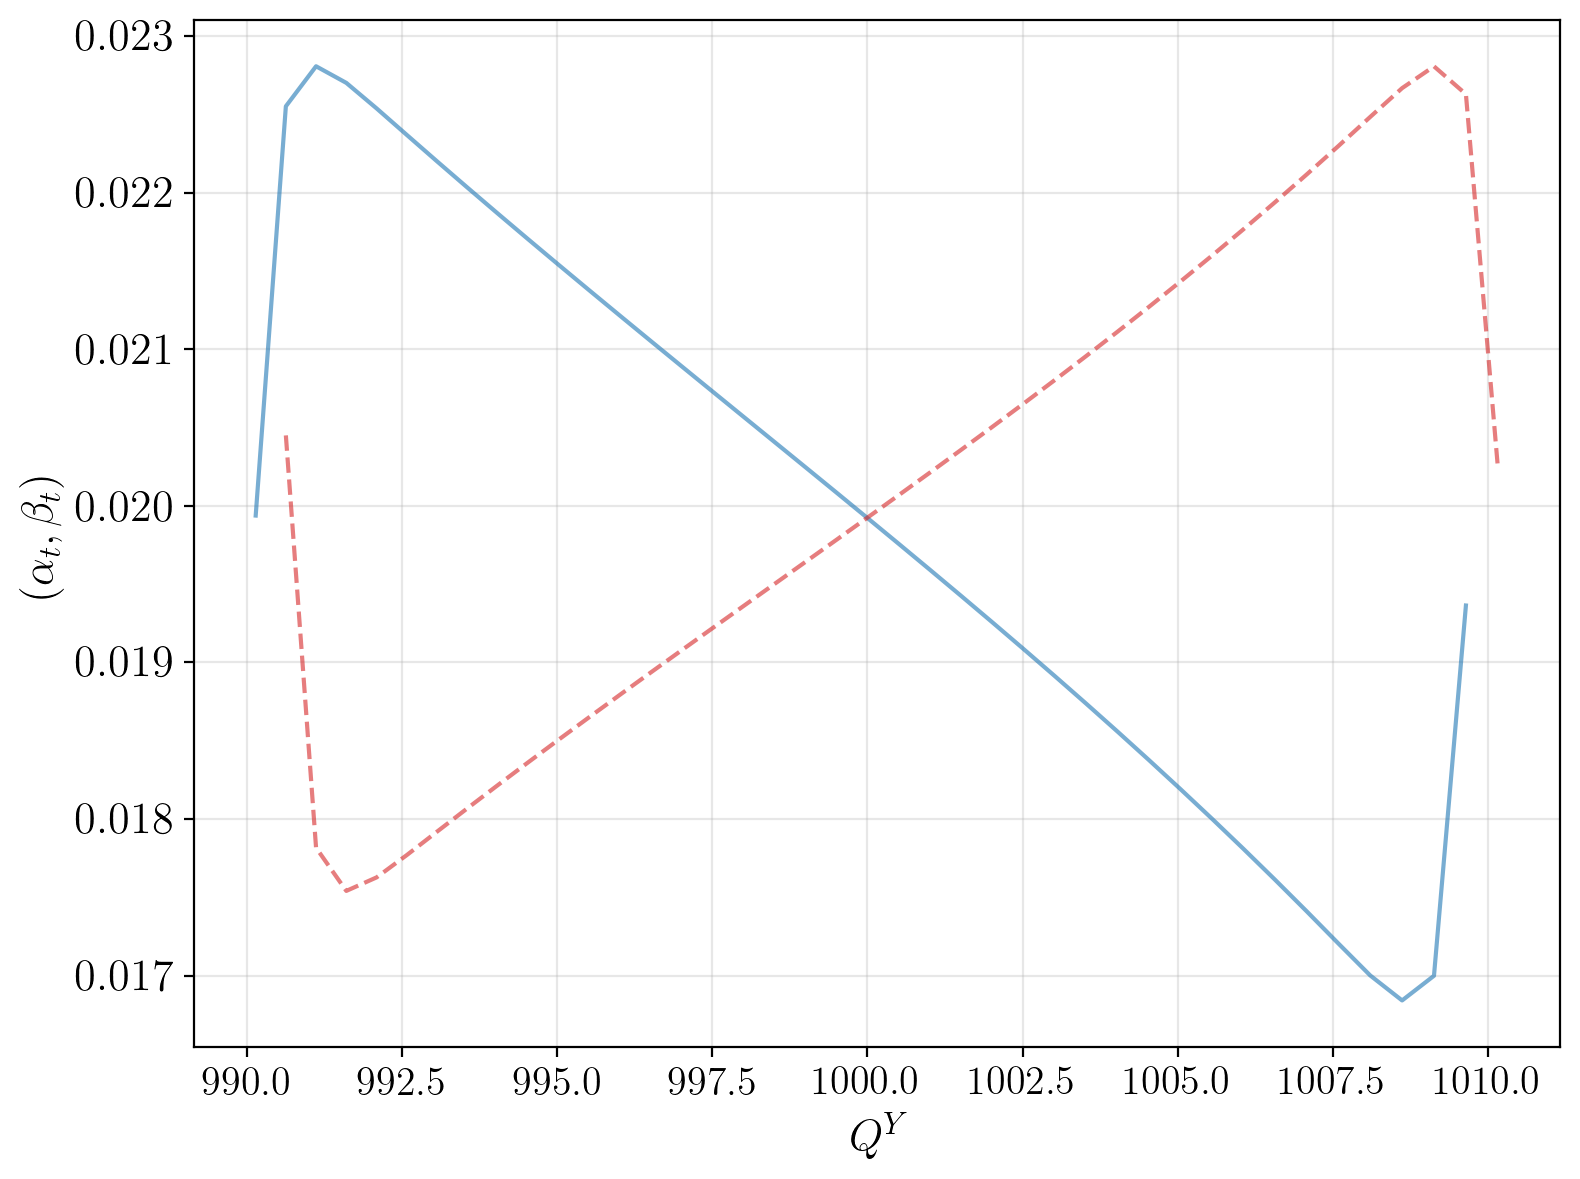

In [81]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, alpha[:], '-', color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, beta[:], '--', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Grid Equispaced in Z/Optimal_Fees.pdf', format="pdf", dpi=dpi)
plt.show()

In [82]:
lin_alpha, lin_beta = AMM.get_linear_fees(0.5)

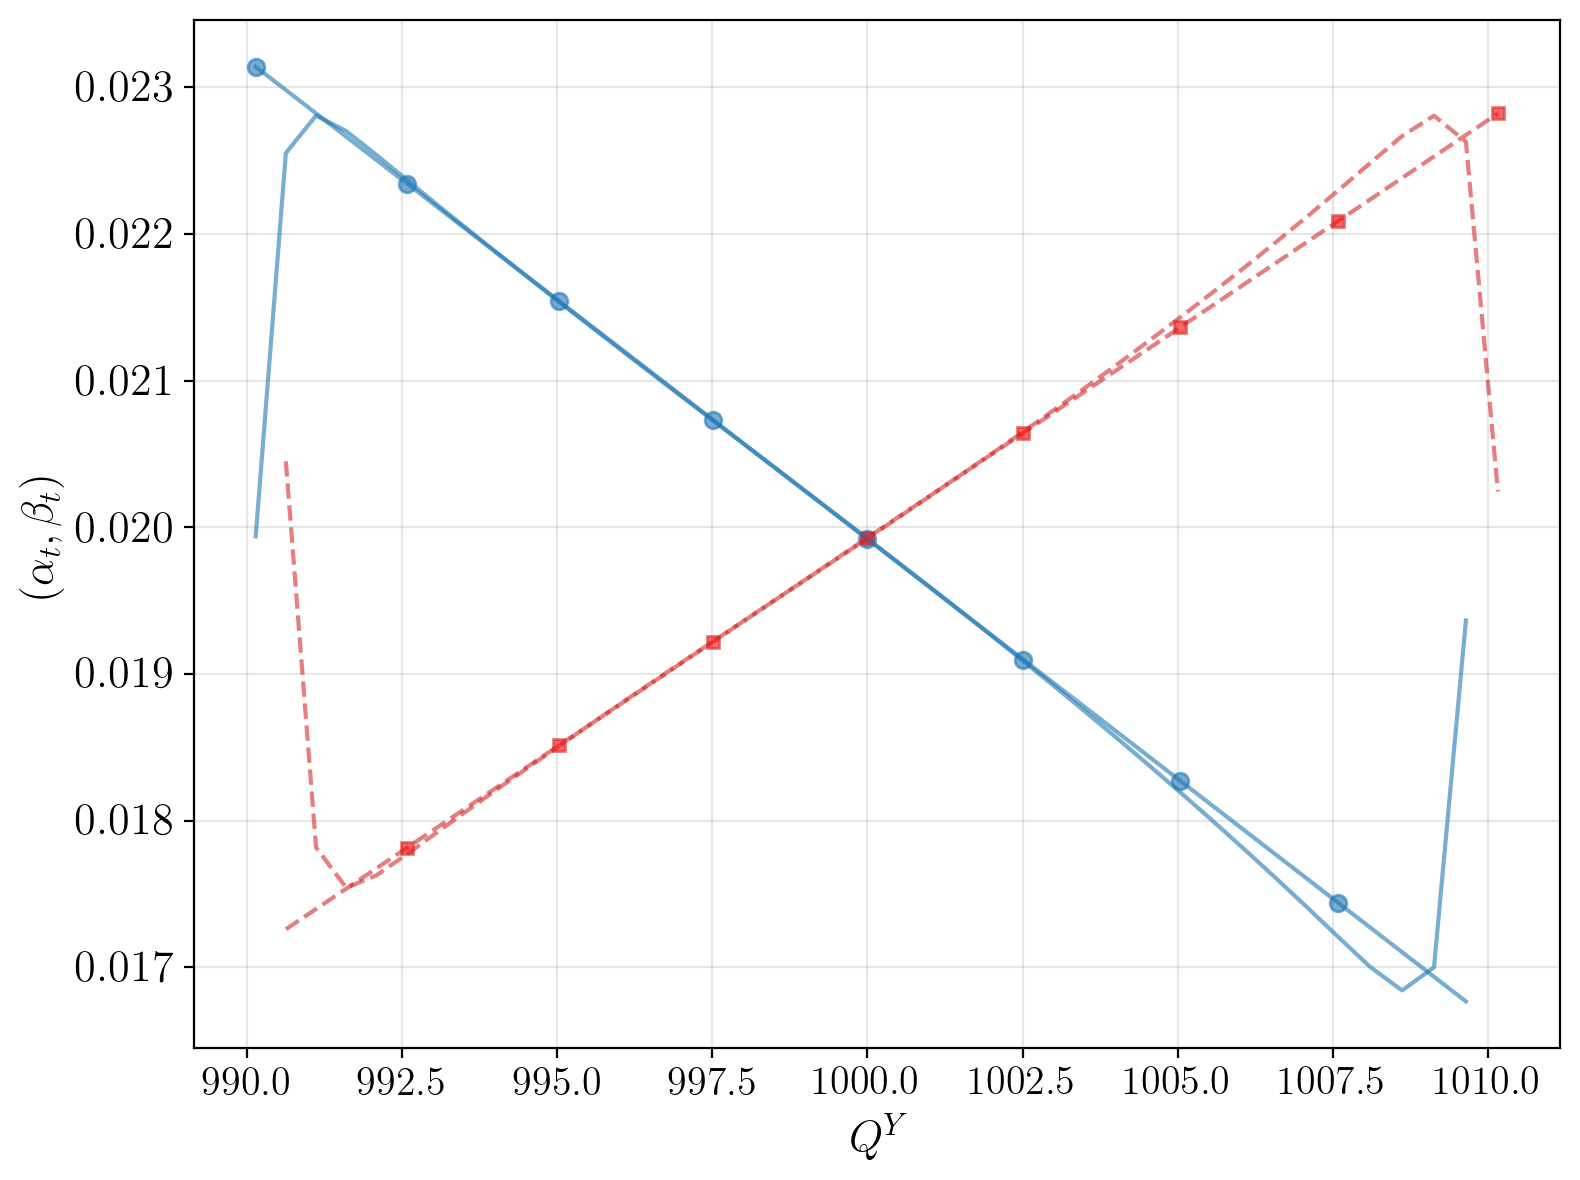

In [83]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), sharey=False, sharex=True)

ax.plot(AMM.y_grid, lin_alpha[:], '-o', color='tab:blue', alpha=0.6, markevery=5)
ax.plot(AMM.y_grid, lin_beta[:], '--s', color='tab:red', alpha=0.6, markersize=4, markerfacecolor='red', markevery=5)
ax.plot(AMM.y_grid, alpha[:], '-', color='tab:blue', alpha=0.6)
ax.plot(AMM.y_grid, beta[:], '--', color='tab:red', alpha=0.6)

plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Grid Equispaced in Z/Linear_Fees.pdf', format="pdf", dpi=dpi)
plt.show()

In [84]:
pen_const_value = np.zeros(6)
for i in range(0,5):
    pen_const_value[i+1] = 10**i

In [85]:
alpha = np.ones((len(AMM.y_grid), len(pen_const_value)))
beta = np.ones_like(alpha)
for i, pen_const in enumerate(pen_const_value):
    params_new_grid["pen_const"] = pen_const
    AMM_aux = utils.AMM(**params_new_grid)
    alpha[:,i], beta[:,i] = AMM_aux._calculate_fees_t(0.5)

In [86]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin = min(pen_const_value), vmax = max(pen_const_value))
sm = ScalarMappable(norm = norm, cmap=cmap)

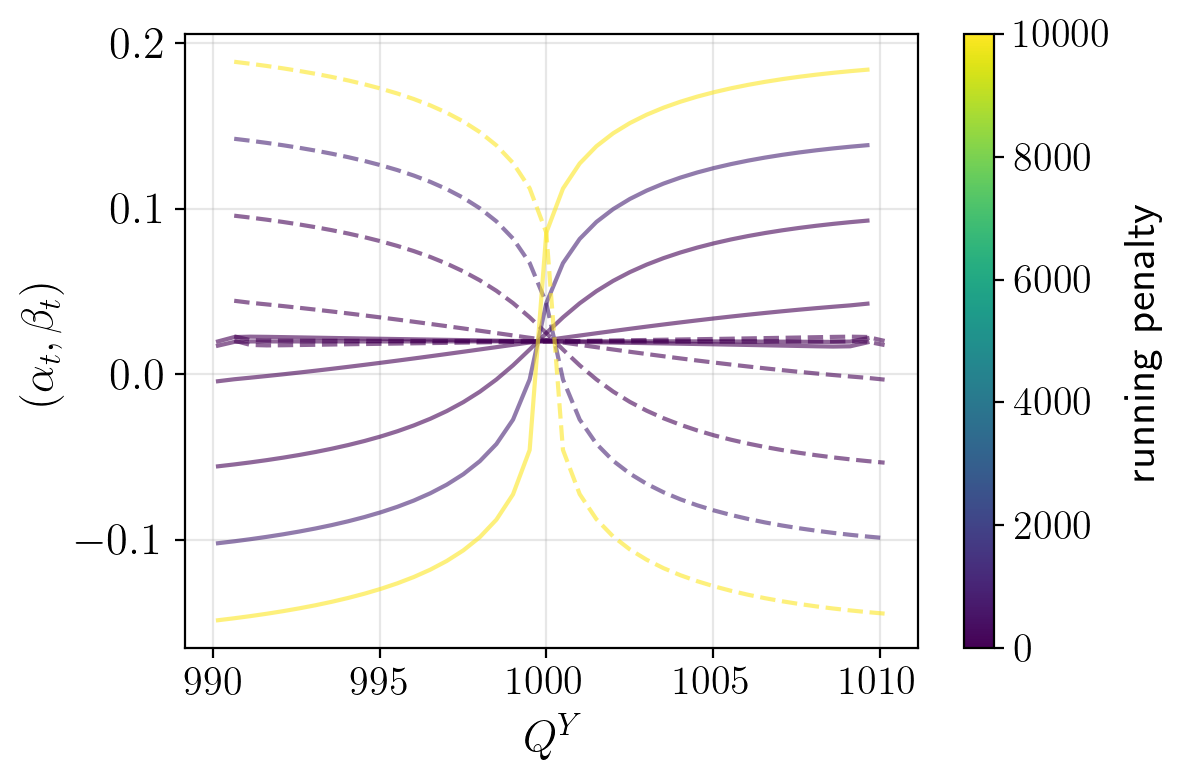

In [87]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

for i,p in enumerate(pen_const_value):
    color = cmap(norm(pen_const_value[i]))
    ax.plot(AMM.y_grid, alpha[:,i], '-', color=color, alpha=0.6)
    ax.plot(AMM.y_grid, beta[:,i], '--', color=color, alpha=0.6)


plt.grid(alpha=0.3)
plt.xlabel(r'$Q^Y$', fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$(\alpha_t, \beta_t)$', fontsize=fs)

cbar = fig.colorbar(sm, ax = ax, orientation = "vertical")
cbar.set_label("running penalty", fontsize=fs)

plt.tight_layout()
plt.savefig('figures/Grid Equispaced in Z/Optimal_Fees_Nonzero_penalty.pdf', format="pdf", dpi=dpi)
plt.show()

In [88]:
Nt = 100
t_vector = np.linspace(0, AMM.T,num=Nt)

alpha = np.ones((len(AMM.y_grid), len(t_vector)))
beta = np.ones_like(alpha)

for i,t in enumerate(t_vector):
    alpha[:,i],beta[:,i] = AMM._calculate_fees_t(t)

In [89]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(AMM.y_grid), vmax=max(AMM.y_grid))
sm = ScalarMappable(norm=norm, cmap=cmap)

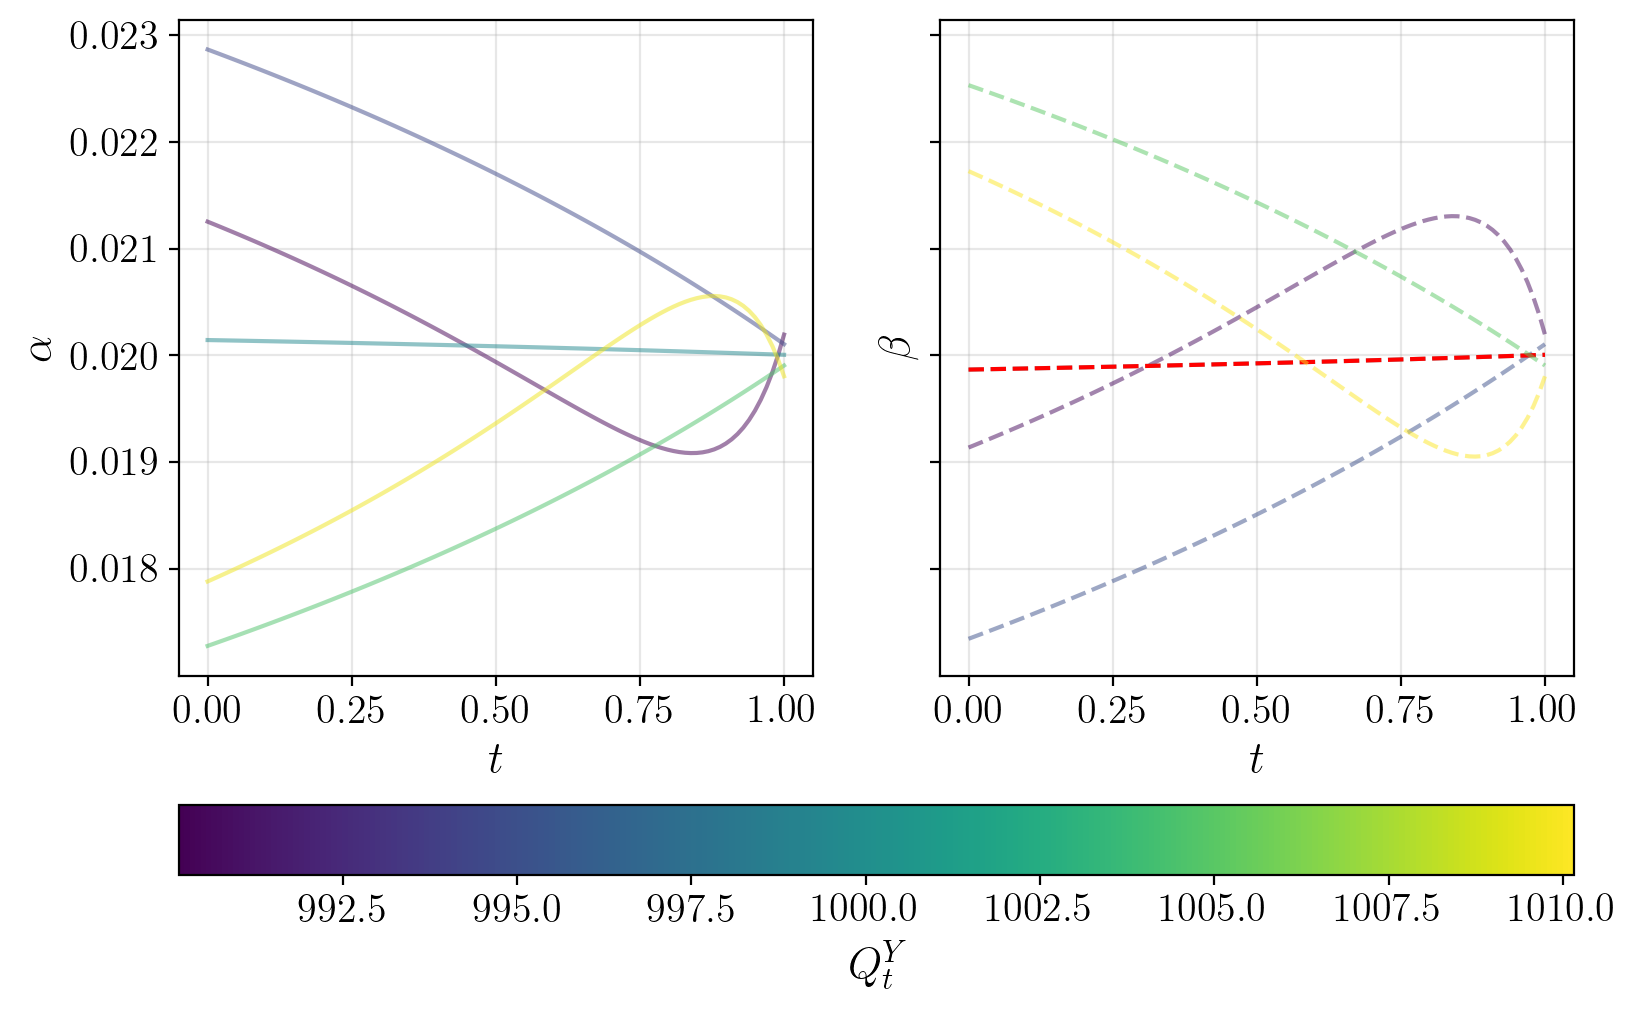

In [90]:
fig, ax = plt.subplots(1,2, figsize = (9,6), sharey=True)
indices_alpha = np.linspace(0, len(alpha)- 2, 5, dtype=int)
indices_beta = np.linspace(1, len(alpha)- 1, 5, dtype=int)
desired_values_alpha = [y_grid[i] for i in indices_alpha]
desired_values_beta = [y_grid[i] for i in indices_beta]
for i,q in enumerate(AMM.y_grid):
    if q in desired_values_alpha:
        color = cmap(norm(AMM.y_grid[i]))
        if q < desired_values_beta[-1]:
            ax[0].plot(t_vector, alpha[i,:],'-', color = color, alpha = 0.5)#, label="q="+str(q), colors[iq])
        if q == AMM.y_0:
            ax[0].plot(t_vector, alpha[i,:],'-', color = "red")#, label="q="+str(q), colors[iq])
    
for i,q in enumerate(AMM.y_grid):
    if q in desired_values_beta:
        color = cmap(norm(AMM.y_grid[i]))
        if q > desired_values_alpha[0]:
            ax[1].plot(t_vector, beta[i,:],'--', color = color, alpha = 0.5) #, label="q="+str(q), colors[iq])
        if q == AMM.y_0:
            ax[1].plot(t_vector, beta[i,:],'--', color = "red") # label=" ", colors[iq])
        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\alpha$', fontsize = fs)
ax[1].set_ylabel(r'$\beta$', fontsize = fs)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.14)
cbar.set_label(r'$Q^Y_t$', fontsize=fs)

#plt.tight_layout()
plt.savefig('figures/Grid Equispaced in Z/Optima_fees_through_time_fct_of_Q_t.pdf', format="pdf", dpi=dpi)
plt.show()

In [103]:
(cash_Opt, quantity_Opt, n_sell_order_Opt, n_buy_order_Opt, min_inventory_Opt, max_inventory_Opt)= AMM.simulate_PnL(nsims = 10000, Nt =1_000, c =0.01, strategy = "Optimal")
(cash_Lin, quantity_Lin, n_sell_order_Lin, n_buy_order_Lin, min_inventory_Lin, max_inventory_Lin)= AMM.simulate_PnL(nsims = 10000, Nt =1_000, c =0.01, strategy = "Linear")
(cash_Const, quantity_Const, n_sell_order_Const, n_buy_order_Const, min_inventory_Const, max_inventory_Const)= AMM.simulate_PnL(nsims = 10000, Nt =1_000, c =0.01, strategy = "Constant")

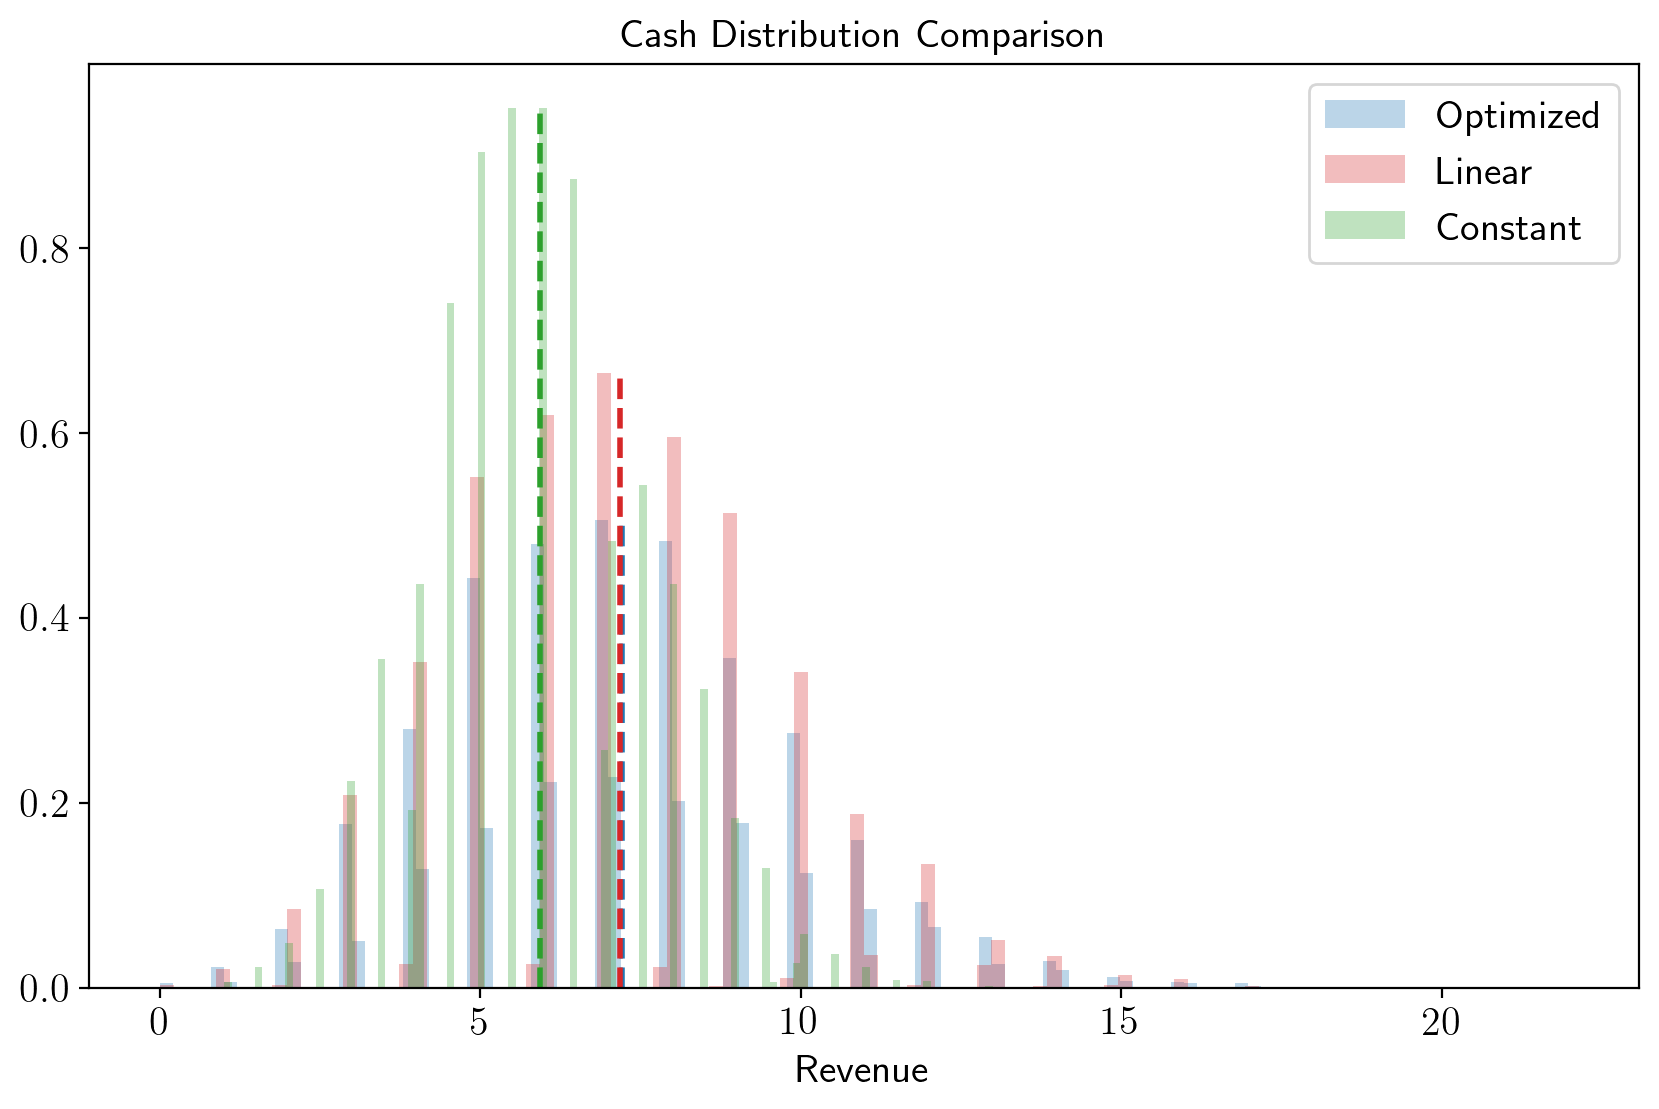

In [104]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and labels
datasets = {
    "Optimized": ("tab:blue", cash_Opt),
    "Linear": ("tab:red", cash_Lin),
    "Constant": ("tab:green", cash_Const),
}

# Plot histograms and mean lines
for label, (color, data) in datasets.items():
    counts, bins, _ = ax.hist(data, bins=100, alpha=0.3, color=color, density=True, label=label)
    ax.vlines(np.mean(data), ymin=0, ymax=max(counts), color=color, linestyle="--", linewidth=2)

# Labels and title
ax.set_xlabel("Revenue")
ax.set_title("Cash Distribution Comparison")
ax.legend()


# Zoom
#plt.xlim([5,10])
plt.savefig('figures/Grid Equispaced in Z/Histogram_Revenue.pdf', format="pdf", dpi=dpi)

# Show plot
plt.show()

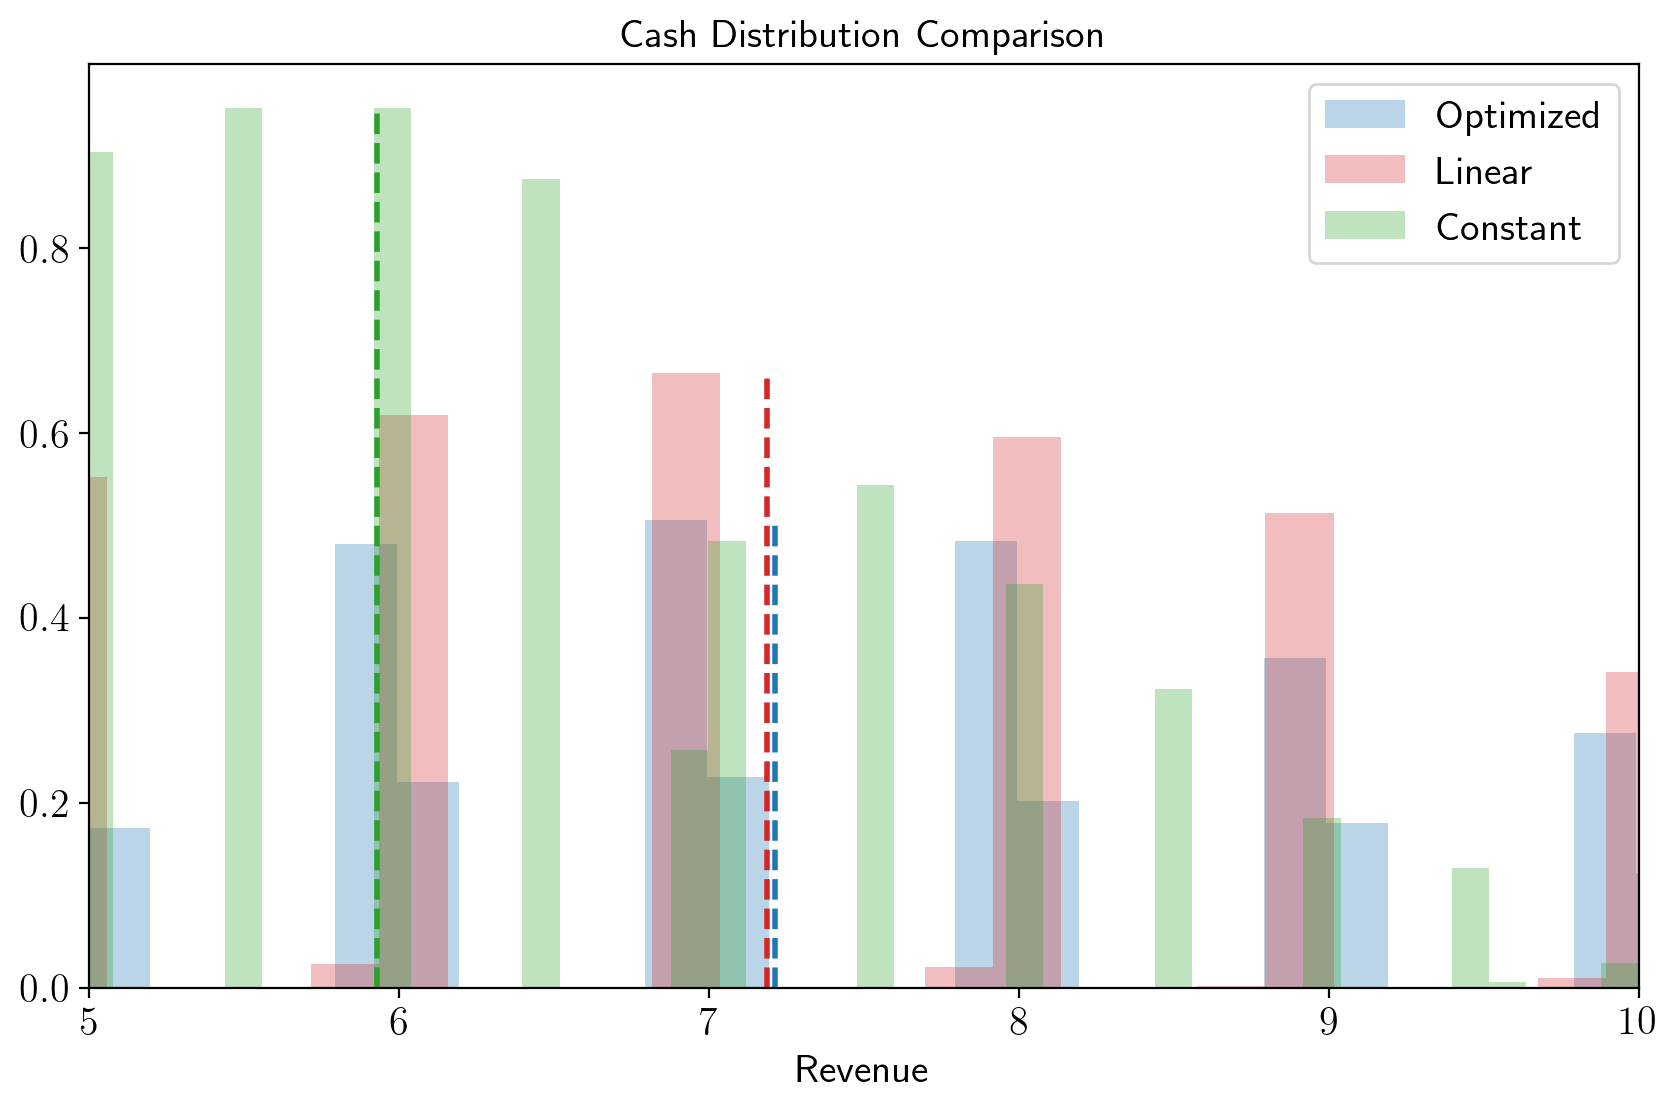

In [105]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and labels
datasets = {
    "Optimized": ("tab:blue", cash_Opt),
    "Linear": ("tab:red", cash_Lin),
    "Constant": ("tab:green", cash_Const),
}

# Plot histograms and mean lines
for label, (color, data) in datasets.items():
    counts, bins, _ = ax.hist(data, bins=100, alpha=0.3, color=color, density=True, label=label)
    ax.vlines(np.mean(data), ymin=0, ymax=max(counts), color=color, linestyle="--", linewidth=2)

# Labels and title
ax.set_xlabel("Revenue")
ax.set_title("Cash Distribution Comparison")
ax.legend()


# Zoom
plt.xlim([5,10])
plt.savefig('figures/Grid Equispaced in Z/Histogram_Revenue_zoomed.pdf', format="pdf", dpi=dpi)

# Show plot
plt.show()

In [106]:
Fees = ["Optimal", "Linear", "Constant 0.1"]
Revenue = [np.mean(cash_Opt),np.mean(cash_Lin),np.mean(cash_Const)]
N_sell_order = [np.mean(n_sell_order_Opt),np.mean(n_sell_order_Lin),np.mean(n_sell_order_Const)]
N_buy_order = [np.mean(n_buy_order_Opt),np.mean(n_buy_order_Lin),np.mean(n_buy_order_Const)]
Final_Inventory = [np.mean(quantity_Opt),np.mean(quantity_Lin),np.mean(quantity_Const)]
Min_inventory = [np.mean(min_inventory_Opt),np.mean(min_inventory_Lin),np.mean(min_inventory_Const)]
Max_inventory = [np.mean(max_inventory_Opt),np.mean(max_inventory_Opt),np.mean(max_inventory_Opt)]

In [107]:
df = pd.DataFrame({
    "Fees": Fees,
    "Revenue": Revenue,
    "N Sell Order": N_sell_order,
    "N Buy Order": N_buy_order,
    "Final Inventory": Final_Inventory,
    "Min Inventory": Min_inventory,
    "Max Inventory": Max_inventory,
})

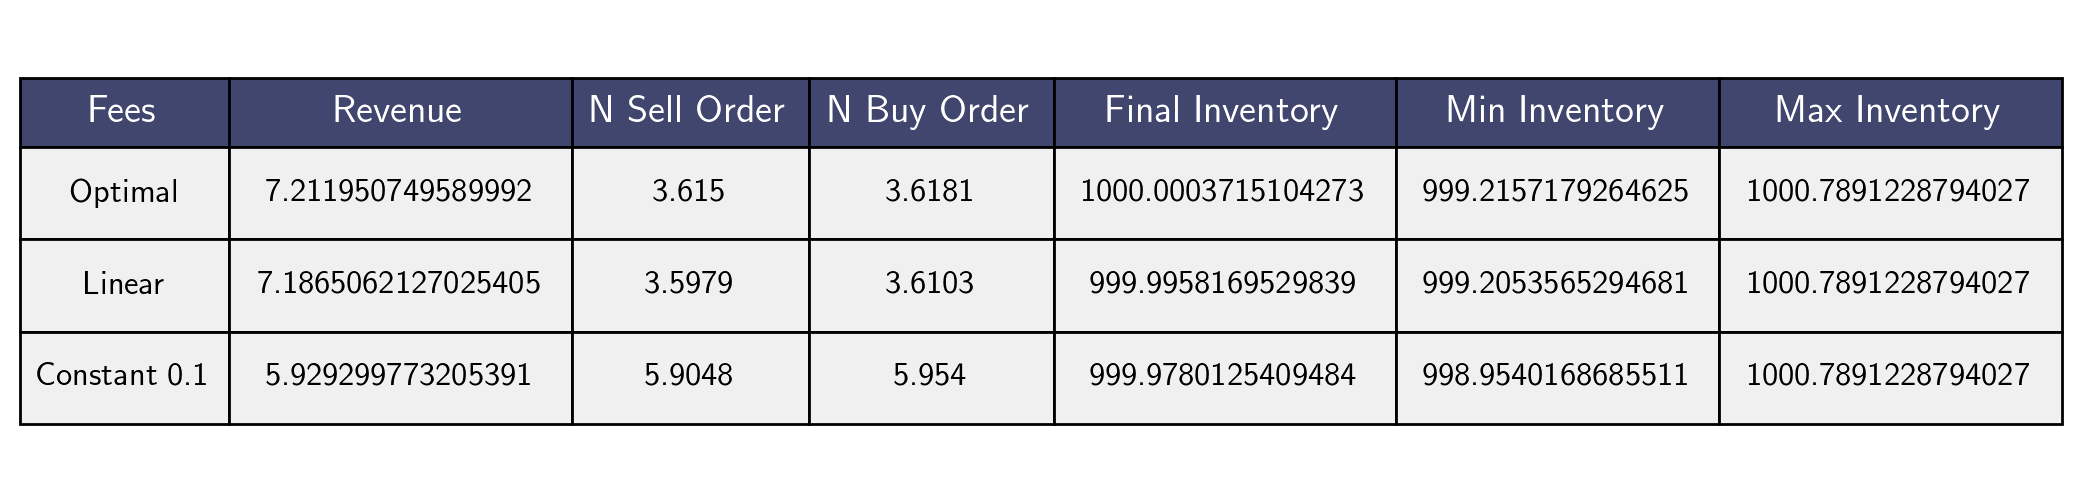

In [108]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))  # Keep image compact
ax.axis('off')  # Hide axis

# Define table colors
header_color = '#40466e'  # Dark blue for header
text_color = 'white'  # White text for header
row_color = '#F0F0F0'  # Light gray for rows

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=[header_color] * len(df.columns)  # Header color
)

# Style table
table.auto_set_font_size(False)
table.set_fontsize(12)  # Bigger text
table.auto_set_column_width(col=list(range(len(df.columns))))  # Auto column width

# Add more padding between rows (increase row height)
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.set_text_props(weight='bold', color=text_color)
        cell.set_fontsize(14)  # Bigger header text
        cell.set_height(0.15)  # Make header taller
    else:  # Data rows
        cell.set_facecolor(row_color)  # Alternating row color
        cell.set_fontsize(12)  # Bigger text
        cell.set_height(0.2)  # More row height for spacing

    cell.set_edgecolor('black')  # Normal border thickness

plt.savefig('figures/Grid Equispaced in Z/Table_values_simulation.pdf', format="pdf", dpi=dpi)